# Bland-Altman examples
Examples of how to use the traditional, non-Bayesian Bland-Altman analysis module.

Run the example in Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ICR-Computational-Imaging/pyomarker/blob/main/examples/bland_altman/bland_altman.ipynb)


In [25]:
!pip install numpy matplotlib pyomarker

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyomarker.models.test_retest.real.bland_altman import BlandAltman

## Create mock test-retest baseline data
We will assume the following:
  - Number of repeat observations: $N = 20$
  - Population mean: $\mu = 4$
  - Coefficient of repeatability: $r = 1.0$
  - Intraclass correlation coefficient: $ICC = 0.8$

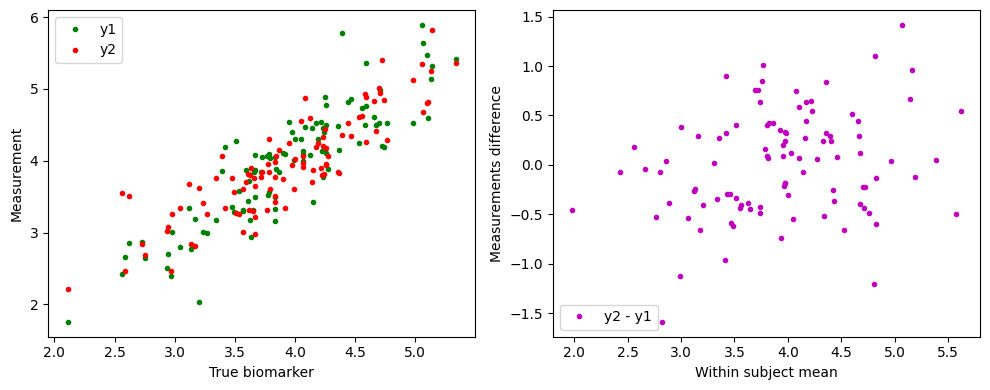

In [2]:
n = 100
icc = 0.8
mu = 4
r = 1.0
sw = r / (1.96 * np.sqrt(2))  # The within subject standard deviation
sb = np.sqrt((icc * sw**2) / (1.0 - icc))  # The between subject standard deviation

np.random.seed(42)
x = np.random.randn(n) * sb + mu
y1 = x + np.random.randn(n) * sw
y2 = x + np.random.randn(n) * sw
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(x, y2, "g.", label = "y1")
ax[0].plot(x, y1, "r.", label = "y2")
ax[0].set_xlabel("True biomarker"), ax[0].set_ylabel("Measurement")
ax[0].legend(loc=2)

ax[1].plot(0.5 * (y1 + y2), y2 - y1, "m.", label = "y2 - y1")
ax[1].set_xlabel("Within subject mean"), ax[1].set_ylabel("Measurements difference")
ax[1].legend(loc=3)

plt.tight_layout()
plt.show()

## Fit the data to the model

This is a point-based estimation to show how to access results of the fit.

In [19]:
ba = BlandAltman(ci = 0.9)
ba.fit(y1, y2)
metrics = ba.metrics()
print(f"Within subject standard deviation: True = {sw:.3f}, Estimate = {metrics['sw']:.3f} (95% CI: {metrics['sw_ci'][0]:.3f} - {metrics['sw_ci'][1]:.3f})")
print(f"Intraclass correlation coefficient: True = {icc:.3f}, Estimate = {metrics['icc']:.3f} (95% CI: {metrics['icc_ci'][0]:.3f} - {metrics['icc_ci'][1]:.3f})")
print(f"Coefficient of reproducibility: True = {r:.3f}, Estimate = {metrics['r']:.3f} (95% CI: {metrics['r_ci'][0]:.3f} - {metrics['r_ci'][1]:.3f})")

Within subject standard deviation: True = 0.361, Estimate = 0.373 (95% CI: 0.335 - 0.423)
Intraclass correlation coefficient: True = 0.800, Estimate = 0.759 (95% CI: 0.679 - 0.821)
Coefficient of reproducibility: True = 1.000, Estimate = 1.035 (95% CI: 0.928 - 1.172)


## Convergence tests
Demonstrate whether confidence intervals converge on the correct solution with increasing Nb

<function matplotlib.pyplot.show(close=None, block=None)>

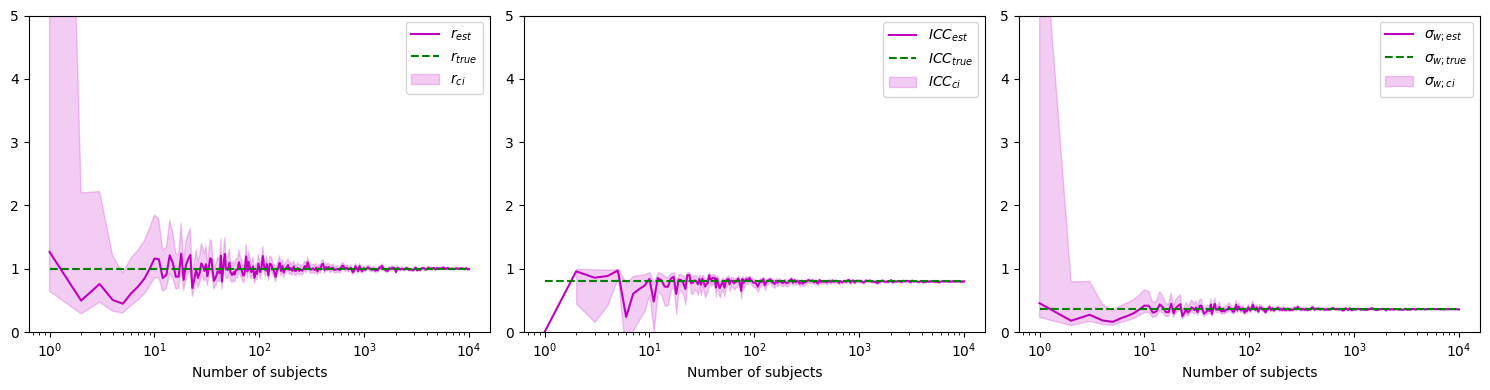

In [23]:
def simulate_metrics(rng, n, mu, sb, sw, ba):
    x = rng.normal(loc=mu, scale=sb, size=n)
    y1 = x + rng.normal(scale=sw, size=n)
    y2 = x + rng.normal(scale=sw, size=n)
    return ba.fit(y1, y2).metrics()

rng = np.random.default_rng(42)
ns = np.unique(np.round(10 ** np.linspace(0, 4, 300)).astype(int))  # int, monotone, no duplicates

metrics_list = [simulate_metrics(rng, int(n), mu, sb, sw, ba) for n in ns]

r_est = np.array([m["r"] for m in metrics_list])
r_ci_est = np.vstack([m["r_ci"] for m in metrics_list])

icc_est = np.array([m["icc"] for m in metrics_list])
icc_ci_est = np.vstack([m["icc_ci"] for m in metrics_list])

sw_est = np.array([m["sw"] for m in metrics_list])
sw_ci_est = np.vstack([m["sw_ci"] for m in metrics_list])


_, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(ns, r_est, "m-", label = r"$r_{est}$")
ax[0].plot(ns, np.repeat(r, len(ns)), "g--", label = r"$r_{true}$")
ax[0].fill_between(ns, r_ci_est[:, 0], r_ci_est[:, 1], color = "m", alpha = 0.2, label = r"$r_{ci}$")
ax[0].set_xscale("log")
ax[0].set_ylim((0, 5))
ax[0].set_xlabel("Number of subjects")
ax[0].legend(loc=1)

ax[1].plot(ns, icc_est, "m-", label = r"$ICC_{est}$")
ax[1].plot(ns, np.repeat(icc, len(ns)), "g--", label = r"$ICC_{true}$")
ax[1].fill_between(ns, icc_ci_est[:, 0], icc_ci_est[:, 1], color = "m", alpha = 0.2, label = r"$ICC_{ci}$")
ax[1].set_xscale("log")
ax[1].set_ylim((0, 5))
ax[1].set_xlabel("Number of subjects")
ax[1].legend(loc=1)

ax[2].plot(ns, sw_est, "m-", label = r"$\sigma_{w;est}$")
ax[2].plot(ns, np.repeat(sw, len(ns)), "g--", label = r"$\sigma_{w;true}$")
ax[2].fill_between(ns, sw_ci_est[:, 0], sw_ci_est[:, 1], color = "m", alpha = 0.2, label = r"$\sigma_{w;ci}$")
ax[2].set_xscale("log")
ax[2].set_ylim((0, 5))
ax[2].set_xlabel("Number of subjects")
ax[2].legend(loc=1)

plt.tight_layout()
plt.show